# Plotting Trajectories
Author: Talia Borofsky  
Date:   Started 2/25/21  
Project: Static environments with limited resources select for multiple foraging strategies rather than conformity  
Description:
- This code plots trajectories for interesting paramater combinations. We first plot $u_1, u_2, r_1, r_2$ trajectories for a population entirely made up of the resident phenogenotype $AB$. Then we show trajectories of $p_1, p_2, r_1, r_2, x, u$ when allele $a$ invades and $p_1, p_2, r_1, r_2, y,u$ when $b$ invades.
- Data structures used are numpy arrays, tuples, lists, and dataframes loaded from csv files in the folder. 
- In particular, note that we use the program ternary to plot ternary plots

In [49]:
import numpy as np
#import importlib
from numpy import linalg
import helperfuns
from helperfuns import *
import DatFrameFuns
from DatFrameFuns import *
import scipy.stats as scs
import matplotlib as mpl
import matplotlib.pyplot as plt
#importlib.reload(helperfuns)
import pandas as pd
#import sympy as sp
#from sympy import *
#from sympy.solvers import solve
#np.set_printoptions(precision=3, suppress = True)
#import seaborn as sns
# next two libraries are used to flatten list of lists
import functools
import operator

# for ternary plots
import ternary


# for formatting tick labels
#from matplotlib.ticker import FormatStrFormatter

#for parallelizing:
import multiprocessing as mp
from pathos.multiprocessing import ProcessingPool as Pool

## Internal Stability

### Functions

In [121]:
# functio make_internal_traj_plots
# Summary: 
#       Plots the trajectories of u1, u2, bu, r1, and r2 when u = 1, 
#       i.e. all individuals are resident type AB
# Parameters
#       init_pts: a dataframe that is a subset of the dataframe from data.csv that shows initial points,
#                 mode parameters, and final equilibrium. Parameters are the same for each initial point
#       colors: The colors corresponding to each row of the init_pts dataframe.
# Returns:
#       returns the axes and figure handles for the ternary plot and the cartesian plot
#       Also returns a dataframe of the trajectories
# Description:
#       u1,u2,bu are plotted in a ternary plot. 
#       r1 and r2 are plotted on a cartesian plot

def make_internal_traj_plots(init_pts, colors):
    # format axes and figures
    fig_u, tax = format_my_ternary() # initiates a ternary plot and formats axes
    fig_r, ax_r = format_r_plot() # initiates cartesian plot and formats axes
    init_pts['color'] = colors # put in column for color
    
    # for each initial point, we find the trajectory and plot it
    # we want to record these trajectories. I'll make a dataframe of points for each trajectory, 
    # and then stack these dataframes into one master frame
    
    nrow = len(init_pts)
    row_list = np.array_split(init_pts,nrow)
    trajectory_list = [get_and_plot_trajectory(row,fig_u,tax,fig_r,ax_r) for row in row_list]
    trajectories_df = pd.concat(trajectory_list) # makes a matrix
    # colnames = ["u1","u2","bu","r1","r2","timestep","color"]
    # trajectories_df = pd.DataFrame(trajectories_mat,columns = colnames)
    
    trajectories_df = pd.merge(left=trajectories_df, right=init_pts, 
                               on = 'color').sort_values(by=['color','timestep'])

    return(tax, fig_u, ax_r, fig_r, trajectories_df)

def format_my_ternary():
    scale = 30
    fig_u, tax = ternary.figure(scale=scale)
    #TO-DO// FILL IN
    return(fig_u,tax)

def format_r_plot():
    
    fig, ax = plt.subplots(1,1,figsize = (4,4))
        #TO-DO// FILL IN


    return(fig,ax)

# function get_and_plot_trajectory(row, fig_u, tax, fig_r, ax_r)
# Summary: This function iterates from an initial points and plots the trajectory.
# Parameters:
#    row - a row from the init_pts dataframe.
#    fig_u, tax - figure and axis handle for ternary plot of u1, u2, bu
#    fig_r, ax_r - figure and axis handle for plot of r1, r2
# Returns:
#    traj_df, a dataframe with the values of u1, u2, bu, r1, r2 for each time step until they reach the equilibrium
# Description: 
#    uses get_trajectory to iterate until u1 = u1eq (uses the u1eq, r1eq, etc from row)
#    sends this trajectory to plot_my_traj_u and plot_my_traj_r for plotting
def get_and_plot_trajectory(row, fig_u,tax,fig_r,ax_r):
    trajectory_df = get_trajectory(row)
    plot_my_traj_u(trajectory_df,fig_u,tax)
    plot_my_traj_r(trajectory_df,fig_r,ax_r)
    return(trajectory_df)

    
def plot_my_traj_u(traj_df, fig_u, tax):
    return(1)

# function get_trajectory(row)
# parameters:
#     row = a row from the dataframe init_pts

def get_trajectory(row):
    
    # assigning columns to variables for more readability
    K,pc,D,beta, u1, u2, bu, r1, r2 = np.transpose(row[['K','pc','D','beta', 'u1init','u2init',
                                                       'buinit', 'r1init','r2init']].values)
    uvec = [u1,u2,bu]; rvec = [r1,r2]
    xvec = [0,0,0]
    yvec = [0,0,0]
    list_rows = []
    for t in range(0,200000):
        curr_row = pd.DataFrame({"u1":uvec[0], "u2": uvec[1], "bu": uvec[2], "r1":rvec[0], "r2": rvec[1],
                                 "tstep":t, "color":row.color})
        list_rows.append(curr_row)
        if np.allclose([*uvec,*rvec], row[['u1eq','u2eq','bueq','r1eq','r2eq']],rtol = 1e-6, atol = 1e-6):
            break
        else:
            uvec,xvec,yvec,rvec,W = NextGen(uvec,xvec,yvec,rvec,D,K,pc,beta)
    
    traj_df =  pd.concat(list_rows) 
    return(traj_df)
        
        # use break to leave for loop once at equilibrium
    u1vec = [0,0]
    u2vec = [0,0]
    buvec = [1,1]
    r1vec = [1,1]
    r2vec = [1,1]
    tstep = [1,2]
    color = ['r','c']
    to_return = pd.DataFrame({"u1":u1vec, "u2":u2vec,"bu":buvec, "r1":r1vec, "r2": r2vec, "timestep": tstep, "color":color })
    return(to_return)

def plot_my_traj_r(traj_df, fig_r, ax_r):
    return(1)


### Load DataFrames

In [117]:
df_UniqueEquilibria = pd.read_csv('UniqueEquilibriaDF.csv')
df_InitialPoints = pd.read_csv('data.csv')

### Choose paramater combo to look at and initial points
Store the equilibria. We will use this for stopping the trajectory function

I'll choose a value where there is moderate food dpletion ($\beta = 0.5$) and poor information ($\mu = -0.5$)

In [118]:
# choose equilibria where 
row_init_eq = df_UniqueEquilibria.query('K==0 & x_pos_invades==True & beta == 0.5 & D==0 & mu==-0.5')
init_pts_all = df_InitialPoints.query('K==0 & beta == 0.5 & D==0 & mu == -0.5')
init_pts = init_pts_all.sample(4)


### For each initial point, plot trajectory
Using stored equilibrium to check when to stop

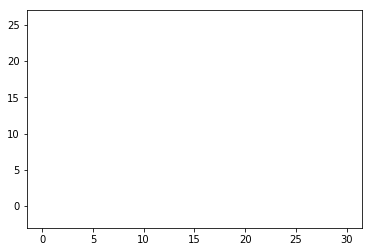

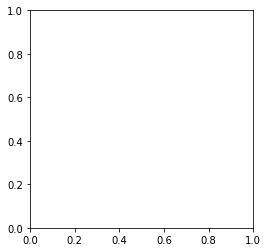

In [119]:
tax, fig_u, ax_r, fig_r, trajectories_df = make_internal_traj_plots(init_pts, colors)

In [88]:
to_return

,u1,u2,bu,r1,r2,timestep,color
0,0.0,0.0,1,1.0,1.0,1,r
1,0.5,0.5,0,0.2,0.5,2,c


In [86]:
init_pts.color

['k', 'c', 'm', 'r']